In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from simulator import get_simulator
from simulate import simulate
from simulate import mpi_simulate

# Simulating The Chemical Network 

# $e^{i\pi} + 1 = 0$
# $  $

In [2]:
system = {
    'duration': 9999.0, # how much time each simulation trajectory represents
    'resolution': 1.0,  # how often the state of the system is recorded for output
    'species': [
        ('i', 0),  # competing protein mRNA (CFP mRNA)
        ('a', 0),  # antitoxin mRNA (mazE)
        ('t', 0),  # toxin mRNA (mazF)
        ('I', 0),  # competing protein (CFP)
        ('A', 0),  # antitoxin (MazE)
        ('T', 0),  # toxin (MazF)
        ('TT', 0), # toxin dimer
        ('C', 0),  # toxin-antitoxin complex (MazE bound to MazF dimer)
        ('CC', 0), # toxin-antitoxin complex dimer
    ],
    'reactions': [
        ('lambda_i', (), ((1, 'i'), )), # transcription of competing protein mRNA
        ('lambda_ta', (), ((1, 't'), (1, 'a'))), # transcription of toxin and antitoxin mRNAs

        ('F_i', ((1, 'i'), ), ()), # cleavage of competing protein mRNA by free toxin
        ('F_a', ((1, 'a'), ), ()), # cleavage of antitoxin mRNA
        ('F_t', ((1, 't'), ), ()), # cleavage of toxin mRNA

        ('alpha_i', ((1, 'i'), ), ((1, 'i'), (1, 'I'))), # translation of competing protein
        ('alpha_a', ((1, 'a'), ), ((1, 'a'), (1, 'A'))), # translation of antitoxin
        ('alpha_t', ((1, 't'), ), ((1, 't'), (1, 'T'))), # translation of toxin

        ('k_C', ((2, 'T'), ), ((1, 'TT'), )), # toxin dimer formation
        ('k_C', ((1, 'TT'), (1, 'A')), ((1, 'C'), )), # complex formation
        ('k_C', ((2, 'C'), ), ((1, 'CC'), )), # complex dimerization

        ('G_I', ((1, 'I'), ), ()), # degradation of competing protein
        ('G_A', ((1, 'A'), ), ()), # degradation of antitoxin
        ('G_T', ((1, 'T'), ), ()), # degradation of toxin
        ('G_T', ((1, 'TT'), ), ((1, 'T'), )), # degradation of toxin bound in toxin dimer
        ('G_C', ((1, 'C'), ), ((1, 'TT'), )), # degradation of antitoxin bound in complex
        ('G_C', ((1, 'CC'), ), ((1, 'TT'), (1, 'C'))), # degradation of antitoxin bound in complex dimer

        ('Gamma', ((1, 'i'), ), ()),                     # dilution of competing protein mRNA
        ('Gamma', ((1, 'a'), ), ()),                     # dilution of antitoxin mRNA
        ('Gamma', ((1, 't'), ), ()),                     # dilution of toxin mRNA
        ('Gamma', ((1, 'I'), ), ()),                     # dilution of competing protein
        ('Gamma', ((1, 'A'), ), ()),                     # dilution of antitoxin
        ('Gamma', ((1, 'T'), ), ()),                     # dilution of toxin
        ('Gamma', ((1, 'TT'), ), ()),                    # dilution of toxin dimer
        ('Gamma', ((1, 'C'), ), ()),                     # dilution of complex
        ('Gamma', ((1, 'CC'), ), ()),                    # dilution of complex dimer
    ], 
    'variables': [
        ('lambda_i', 20.0), # transcription rate competing protein mRNA
        ('sigma_ta', 20.0), # basal transcription rate of toxin and antitoxin mRNAs
        ('alpha_i', 200.0), # translation rate of competing protein mRNA
        ('alpha_t', 200.0), # translation rate of toxin
        ('mu_i', 5.0),      # basal degradation rate of competing protein mRNA
        ('k_0', 0.05),      # basal repression factor for toxin antitoxin mRNA
        ('nu', 1.6),        # relative translation rate of antitoxin to toxin
        ('k_C', 1000.0),    # rate of complex formation
        ('mu_ta', 5.0),     # basal degradation rate of toxin and antitoxin mRNAs
        ('f_T', 20.0),      # mRNA cleavage factor by free toxin
        ('omega', 0.2),     # relative cleavage rate of antitoxin to toxin
        ('delta', 1.5),     # relative cleavage rate of competing protein to toxin
        ('mu', 100.0),      # degradation velocity of all proteolytic pathways
        ('epsilon', 0.01),  # affinity of non-degradation state
        ('kappa_I', 1.0),   # affinity factor of competing protein
        ('kappa_M', 1.0),   # affinity factor of entire toxin antitoxin module
        ('kappa_A', 1.0),   # affinity factor of antitoxin
        ('kappa_T_1', 0.00001),   # affinity factor of toxin
        #('kappa_T_2', 0.00001),   # affinity factor of toxin
        ('kappa_C', 0.1),   # affinity factor of complex
        ('gamma', 1.0),     # basal dilution rate (sets the time units of the system)
        ('beta_g', 0.25),   # growth rate factor for inhibition of growth by free toxin
        ('eta_p', 0.5),     # proteolytic coupling parameter
        ('phi', 1.0),
    ], 
    'functions': [
        ('lambda_ta', 'sigma_ta / (1 + k_0 * (A + C + CC))'), # rate of toxin and antitoxin mRNAs
        
        ('alpha_a', 'alpha_t * nu'), # nu > 1 so that translation of antitoxin is faster than toxin

        ('F_t', 'mu_ta + f_T * (T + TT)'), # cleavage of toxin mRNA which increases as toxin accumulates
        ('F_i', 'mu_i  + f_T * (T + TT) * delta'), # delta = 1.5 so that competing protein mRNA cleavage is faster
        ('F_a', 'mu_ta + f_T * (T + TT) * omega'), # omega = 0.2 so that antitoxin mRNA cleavage is slower than toxin

        ('M_1', '(kappa_A * A + kappa_C * (C + CC) + kappa_T_1 * (T + TT))'),
        ('M_2', '(kappa_A * A + kappa_C * (C + CC) + kappa_T_2 * (T + TT))'),

        ('kappa_T_2', 'phi * kappa_T_1'),
        ('kappa_p_1', 'eta_p'),
        ('kappa_p_2', '1.0 - eta_p'),
        
        ('G1', 'mu / (epsilon + kappa_p_2 * kappa_I * I + kappa_M * M_1)'),
        ('G2', 'mu / (epsilon + kappa_p_1 * kappa_I * I + kappa_M * M_2)'),
        ('G_I', '(          kappa_I) * (kappa_p_2 * G1 + kappa_p_1 * G2)'),
        ('G_A', '(kappa_A * kappa_M) * (G1 + G2)'),
        ('G_C', '(kappa_C * kappa_M) * (G1 + G2)'),
        ('G_T', '(          kappa_M) * (kappa_T_1 * G1 + kappa_T_2 * G2)'),

        
        ('Gamma', 'gamma / (1.0 + beta_g * (T + TT))'),

        ('T_free', 'T + TT'), 
    ], 
    #'targets': ['time', 'i', 'I', 'A', 'C', 'CC', 'T', 'TT', 'T_free'],
    'targets': ['time', 'T_free'],
}

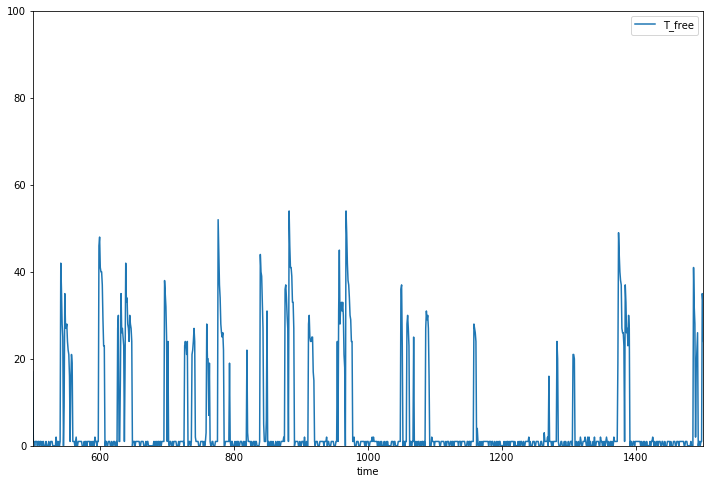

In [9]:
df = pd.DataFrame(OrderedDict((t, d) for t, d in zip(system['targets'], get_simulator(system)(0, lambda_i=15))))
df.plot(x='time', y=['T_free'], kind='line', figsize=(12, 8), xlim=(500, 1500), ylim=(0, 100))

# Measurements Of Toxicity Over Parameter Space 

In [ ]:
np.round(np.exp(np.linspace(np.log(0.01), np.log(100), 5)), 3)

In [ ]:
np.round(np.exp(np.linspace(np.log(0.0000001), np.log(1), 8)), 10)

In [ ]:
np.round(np.exp(np.linspace(np.log(1), np.log(100), 3)), 3)

In [4]:
from event_detection import event_detection
from pscan import pscan_view

processing = (
    (event_detection, ('time', 'T_free')), 
)

axes = (
    ('lambda_i', np.arange(0, 50 + 1e-10, 5)),
    ('kappa_I', np.round(np.exp(np.linspace(np.log(0.0000001), np.log(1), 10)), 10)),
    ('eta_p', np.arange(0.0, 1.0 + 1e-10, 0.1)),
    ('phi', np.round(np.exp(np.linspace(np.log(1), np.log(100), 3)), 3)),
    #('kappa_I', np.round(np.exp(np.linspace(np.log(0.0000001), np.log(1), 50)), 10)),
    #('eta_p', np.arange(0.0, 1.0 + 1e-10, 0.02)),
    #('phi', np.round(np.exp(np.linspace(np.log(1), np.log(100), 3)), 3)),
)

print('the axes:')
for a, v in axes:
    print(a, v)

#pspace, data = simulate(system, processing=processing, batchsize=10, axes=axes)
pspace, pscans = mpi_simulate(system, processing=processing, batchsize=10, axes=axes, hostfile='~/dev/hostfile')

Scanning Parameters:   0%|          | 0/3630 [00:00<?, ?it/s]

the axes:
lambda_i [  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.]
kappa_I [  1.00000000e-07   5.99500000e-07   3.59380000e-06   2.15443000e-05
   1.29155000e-04   7.74263700e-04   4.64158880e-03   2.78255940e-02
   1.66810054e-01   1.00000000e+00]
eta_p [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
phi [   1.   10.  100.]


started worker 3 / -1:   0%|          | 0/3630 [00:13<?, ?it/s]

setting up workers


started worker 8 / -1:   0%|          | 0/3630 [00:29<?, ?it/s] 

Compiling ./gillespie_7.pyx because it changed.
[1/1] Cythonizing ./gillespie_7.pyx
running clean
removing 'build/temp.linux-x86_64-3.6' (and everything under it)
removing 'build'
running build_ext
building 'gillespie_7' extension
creating build/temp.linux-x86_64-3.6
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/srv/cluster/anaconda3/lib/python3.6/site-packages/numpy/core/include -I/srv/cluster/anaconda3/include/python3.6m -c ./gillespie_7.c -o build/temp.linux-x86_64-3.6/./gillespie_7.o


worker 5 / -1 setup up:   0%|          | 0/3630 [00:35<?, ?it/s]

gcc -pthread -shared -L/srv/cluster/anaconda3/lib -Wl,-rpath=/srv/cluster/anaconda3/lib,--no-as-needed build/temp.linux-x86_64-3.6/./gillespie_7.o -L/srv/cluster/anaconda3/lib -lpython3.6m -o /srv/cluster/mini_gillespiem/.simulators/gillespie_7.cpython-36m-x86_64-linux-gnu.so


worker 13 / -1 setup up:   0%|          | 0/3630 [00:36<?, ?it/s]

set up workers


worker 21 / -1 ran location: 100%|██████████| 3630/3630 [4:46:00<00:00,  2.04s/it]  

saving output data...
worker 7 halt
worker 3 halt
worker 6 halt
worker 5 halt
worker 8 halt
worker 19 halt
worker 4 halt
worker 1 halt
worker 10 halt
worker 17 halt
worker 2 halt
worker 22 halt
worker 15 halt
worker 23 halt
worker 20 halt
worker 21 halt
worker 13 halt
worker 14 halt
worker 9 halt
worker 11 halt
worker 18 halt
worker 16 halt
worker 12 halt
saved output data
end dispatch 0 ./.simulators/run.json


loading output data...
loaded output data


# Viewing Measurements 

In [ ]:
pscans[0]

In [ ]:
pscan = pscans[0]
subspace = {
    #'kappa_T': 0.0000001, 
    #'kappa_T': 0, 
    'kappa_I': 0.1, 
    #'kappa_M': 0.5, 
    #'lambda_i': 20, 
    'phi': 10.0, 
}
targets = ('time', 'T_free')

selection = pscan_view(pscan, subspace, targets)
selection.shape, selection.columns

trajectory = 0
target = 'T_free'

time_selection = selection.loc[selection['Target'] == 'time'].reset_index()
target_selection = selection.loc[selection['Target'] == target].reset_index()

n_fig = target_selection.shape[0]
f, axes = plt.subplots(n_fig, 1, figsize=(12, 2 * n_fig))
f.subplots_adjust(wspace=0.8, hspace=0.8)
for (t, time), (l, location), ax in zip(time_selection.iterrows(), target_selection.iterrows(), axes):
    subspace = location[pspace.columns]
    subspace = ', '.join(('%s: %s' % (i, j)) for i, j in zip(subspace.index, subspace.values))
    ax.set_title('location: %s' % subspace)
    counts = location['Batch'][trajectory, :]
    time = time['Batch'][trajectory, :]
    ax.plot(time, counts, linewidth=3)
    events = location['Events']
    if events and sum([len(e) for e in events]):
        parameters = location['Parameters']
        high, low = parameters['high'], parameters['low']
        medium = (high + low) / 2.0
        ax.plot([time[0] - 1, time[-1] + 1], [low, low], color='k', ls='--')
        ax.plot([time[0] - 1, time[-1] + 1], [medium, medium], color='k', ls='--')
        ax.plot([time[0] - 1, time[-1] + 1], [high, high], color='k', ls='--')
        for i, j in events[trajectory]:
            ax.plot([time[i], time[j]], [medium, medium], color='r', lw=5, marker='s')
    ax.set_xlim((0.2 * time.shape[0], min(0.2 * time.shape[0] + 1000, time[-1])))

In [ ]:
target_selection.columns

In [ ]:
pscan = pscans[0]
subspace = {
    #'kappa_T': 0.0000001, 
    #'kappa_T': 0, 
    'kappa_I': 0.1, 
    #'kappa_M': 1.0, 
    #'lambda_i': 5, 
    'phi': 100.0, 
}
targets = ('time', 'T_free')

selection = pscan_view(pscan, subspace, targets)
selection.shape, selection.columns

trajectory = 0
target = 'T_free'

time_selection = selection.loc[selection['Target'] == 'time'].reset_index()
target_selection = selection.loc[selection['Target'] == target].reset_index()

x = 'eta_p'
ys = [['Toxic Probability'], ['Mean Event Duration'], ['Event Count']]

#print(target_selection[x])

n = len(ys)
f, axes = plt.subplots(n, 1, figsize=(12, n * 6))
for ax, targets in zip(axes, ys):
    target_selection.plot(x=x, y=targets, ax=ax)
    ax.set_title('%s Versus %s' % (', '.join(targets), x))
    ax.set_xlabel(x)
    ax.set_ylabel(', '.join(targets))

In [12]:
pscan[pspace.columns]

,eta_p,kappa_I,lambda_i,phi
0,0.0,1.000000e-07,0.0,1.0
1,0.0,1.000000e-07,0.0,1.0
2,0.0,1.000000e-07,0.0,10.0
3,0.0,1.000000e-07,0.0,10.0
4,0.0,1.000000e-07,0.0,100.0
5,0.0,1.000000e-07,0.0,100.0
6,0.1,1.000000e-07,0.0,1.0
7,0.1,1.000000e-07,0.0,1.0
8,0.1,1.000000e-07,0.0,10.0
9,0.1,1.000000e-07,0.0,10.0


(0,) (0,) (0,)
(0,) (0,) (0,)
(0, 0) (0, 0)
(0, 0)


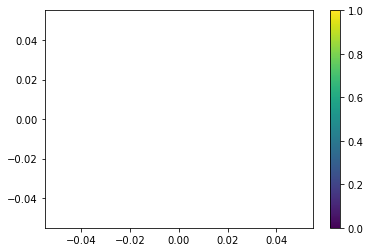

In [13]:
pscan = pscans[0]
subspace = {
    #'kappa_T': 0.0000001, 
    #'kappa_T': 0, 
    'lambda_i': 0.0, 
    #'kappa_I': 0.1, 
    'phi': 100.0, 
    #'sigma_i': 20, 
}
targets = ('time', 'T_free')
target = 'T_free'

selection = pscan_view(pscan, subspace, targets)
selection = selection.loc[selection['Target'] == target].reset_index()
selection.shape, selection.columns

x = selection['kappa_I'].values
#x = selection['phi'].values
y = selection['eta_p'].values
z = selection['Toxic Probability'].values
print(x.shape, y.shape, z.shape)
print(np.unique(x).shape, np.unique(y).shape, z.shape)

X, Y = np.meshgrid(x, y)
print(X.shape, Y.shape)
print(z.reshape(np.unique(x).shape[0], np.unique(y).shape[0]).shape)
plt.pcolor(z.reshape(np.unique(x).shape[0], np.unique(y).shape[0]).transpose())
plt.colorbar()

In [ ]:
selection[['lambda_i', 'eta_p', 'Toxic Probability']].head()